## Step 1
Imports and initialisation of a LJ calculator

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import ase, ase.io
from ase.visualize import view
from ase.optimize import BFGS
from ase.calculators.lj import LennardJones
lj_calc = LennardJones(sigma=1.0, epsilon=1.0, rc=12.0)

## Step 2
Initialisation of the simulation box. Parameters:
- 19 LJ atoms, I've chosen He
- Simulation box, side length is 12 - will adjust and justify with research
- Initialisation of positions, random within the box - will adjust and justify with research

### Simulation Box Length
Chosen 12 as suggested in assignment details

### Initial positions
When randomised across the entire box space, particles are so spaced out that instead of forming one 19-atom cluster, they form mini-clusters (typically 2 - 6 atoms, e.g. see trig-bipyramidal and tetrahedral structures attached). 

The reason for this is that the atoms are so far apart that they are not included in the calculation due to the cut-off (set at 4 Å). Even if the cut-off is increased to the size of the simulation box, the force between particles is so low that they will rarely converge.

So instead of randomising the particles across the entire simulation box, restrict the random space to a theoretical box in the centre of the simulation box that is half the size of entire simulation box.

In [48]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

def initialise_structure(n, box_length):
    
    cell = np.eye(3)*box_length # 3x3 matrix with 
    atoms = ase.Atoms(pbc=True, cell = cell)
    for i in range(n):
        #pos = np.random.rand(3)*cell[1,1] ## randomising positions across the entire simulation box -- doesn't yield desired structure as discussed in the above markdown cell
        pos = np.random.uniform(box_length*0.25, box_length*0.75, size = 3) # generates cartesian coordinates in the center of the simulation box 
        atoms.append(ase.Atom('He', position = pos))

    return atoms

lj_19 = initialise_structure(19, 12)

In [45]:
view(lj_19, viewer='x3d')

## Step 3

Test minimisation to determine parameters `fmax` and `steps` for an appropriate level of convergence.

Through various trials, the energy value (given to 6 decimal places here) doesn't fluctuate much (or at all) below `fmax = 0.001`, thus this seems a reasonable cutoff for a minima such that computation isn't "wasted"

However, I will come back to this, because instpecting fmax across the steps reveals that after 1024 the given trajectory isn't necessarily the lowest energy explored. There should be a way extract the position of the atoms at the lowest energy explored across the 1024 steps if it doesn't converge below `fmax = 0.001`

In [ ]:
def minimise_structure(atoms, f_max=0.001, steps = 1024, id = "test"):
    atoms.calc = lj_calc
    dyn = BFGS(atoms=atoms, trajectory=f'./trajectories/{atoms.symbols}_{id}.traj') # set up BFGS minimiser for the desired Atoms object
    dyn.run(fmax=f_max,steps=steps) # perform minimisation

minimise_structure(lj_19)

      Step     Time          Energy          fmax
BFGS:    0 12:30:03      -62.948752        0.000685


In [47]:
view(lj_19, viewer='x3d')

## Step 4

Performing 100 minimisation cycles starting from a randomised inital structure each time. Generates a database of minim

In [ ]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

energies = []
structures = []

for i in range(100):
    lj_19 = initialise_structure(n = n, box_length = box_length)
    minimise_structure(lj_19, id = i)

    energy = lj_19.get_potential_energy()
    energies.append(energy)
    structures.append(lj_19)

      Step     Time          Energy          fmax
BFGS:    0 12:25:03 150970408833.408783 13787230440463.894531
BFGS:    1 12:25:03     7728.562860   176132.014502
BFGS:    2 12:25:03     7706.609494   176131.811782
BFGS:    3 12:25:03      509.925676     9761.111780
BFGS:    4 12:25:03        3.542629      113.832451
BFGS:    5 12:25:03       -3.387875       58.943155
BFGS:    6 12:25:03       -4.952317       34.482636
BFGS:    7 12:25:03       -6.776123        2.704785
BFGS:    8 12:25:03       -7.332021        2.829121
BFGS:    9 12:25:03       33.787833      391.339606
BFGS:   10 12:25:03       -7.725247        3.036957
BFGS:   11 12:25:03       -8.104730        3.252385
BFGS:   12 12:25:03       -7.001517       31.529041
BFGS:   13 12:25:03       -8.408711        3.303945
BFGS:   14 12:25:03       -8.682665        3.206843
BFGS:   15 12:25:03        6.771999      284.286714
BFGS:   16 12:25:03       -9.209218        5.802059
BFGS:   17 12:25:03       -9.446668        2.819214
BFGS

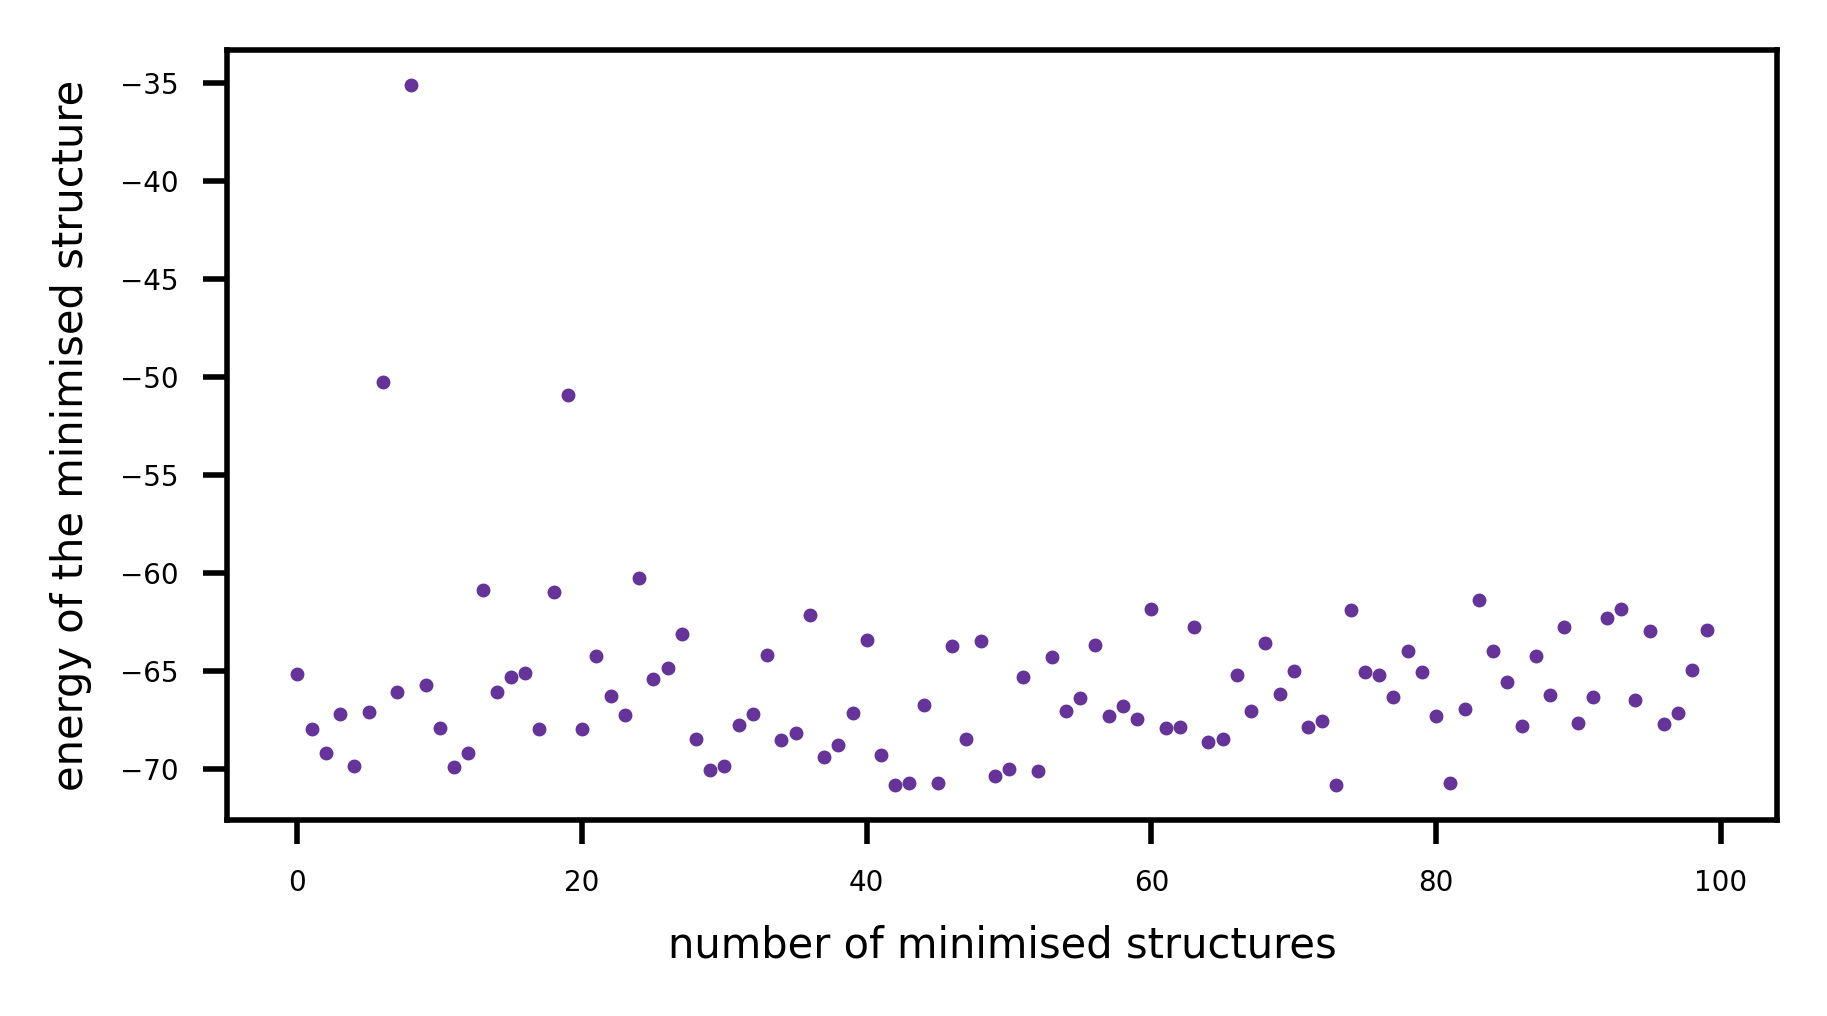

In [57]:
fig=plt.figure(num=None,figsize=(4,2),dpi=500,facecolor='w',edgecolor='k')
plt.tick_params(axis='both', which='major', labelsize=4)
plt.xlabel('number of minimised structures',fontsize=6)
plt.ylabel('energy of the minimised structure',fontsize=6)
plt.scatter(np.arange(len(energies)),energies,color='rebeccapurple',s=1)
plt.savefig('LJ19_min.png')

## Step 5

Implementation of the basin hopping algorithm